# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Исследуем базу данных о продаже квартир в Санкт-Петербурге и Ленинградской области.
Сначала проверим наличие пропусков и обработаем первичные данные - заполним пропуски, поменяем тип данных.
Далее добавим в таблицу новые необходимые для анализа столбцы.
После этого проведем анализ - проанализируем стоимость, площадь, число комнат, высоту потолков. Проанализируем факторы, влияющие на стоимость квартир.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import matplotlib.ticker as ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(12,5)})
data_flat = pd.read_csv('/datasets/real_estate_data.csv',  sep = '\t')
data_flat.head(10)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

Дата сет имеет большое количество попусков, которые необходимо заполнить.
Пропуски в столбцах:is_apartment - заменяем на False, т к аппартаменты это "вид жилья" и пропуск здесь - логичен, т к жилье может быть такого типа. 
Пропуски в столбцах: floors_total заменяем по медиане столбца floor, ceiling_height заменяем по медиане столбца floors_total и отталкиваемся от типа застройки - 50-60 гг. дома строили максимально йэтажности 9 этажей и высота в потолков в таких домах была не более 2.5, современные дома выше 9 этажей. В них потолки ставим по 3-квартилю -2.8м. 
Этажность - заполняем по принципу - если этаж не равен 1 и меньше медианы и в нем пропуск - заполняем значением медианы, если больше медианы - ставим этот этаж и счиатаем, что он последний.
По этому же принципу заполняем пропуски в столбцах с жилой площадью и площадь кухни: площадь кухни заполняем по медиане общей площади квартиры.Если площадь кваритры < 36 м(стандартное значение столбца) - площадь кухни указываем 6 м. Если больше 36 - площадь кухни заполняем по медиане.
Жилая площадь - если общая площадь менее 36 м - жилую площадь указываем 22 м(стандартное знач), в противном случае - заполняем по медиане.
Столбцы с кол-вом балконов - заполняем нулями - предполагаем, что их нет.
Удаленность от парков, аэропортовортов, прудов и водоемов заполняем нулями - если данная инфо не указана - возможно, вблизи таких объектов нет.

### Шаг 2. Предобработка данных

In [2]:
data_flat.info()
data_flat.describe()
#print(data_flat.isnull().sum())
data_flat['is_apartment'] = data_flat['is_apartment'].fillna(value='False') #заменили Nan на пустое значение для удобства в работе

mediana_floor = data_flat['floors_total'].median()
mediana_ceiling = data_flat['ceiling_height'].median()
print(mediana_floor) # медиана общее кол-во этажей
print(mediana_ceiling) #медиана высота потолков


floor = data_flat['floor']

data_flat.loc[data_flat['floor'] <= mediana_floor, 'floors_total']= data_flat.loc[data_flat['floor'] <= mediana_floor, 'floors_total'].fillna(mediana_floor)
data_flat.loc[data_flat['floor'] >= mediana_floor, 'floors_total']= data_flat.loc[data_flat['floor'] >= mediana_floor, 'floors_total'].fillna(floor)
#print(data_flat['floors_total'].value_counts())
#print(data_flat.isnull().sum())

data_flat.loc[data_flat['floors_total'] <= 9, 'ceiling_height']= data_flat.loc[data_flat['floors_total'] <= 9, 'ceiling_height'].fillna(mediana_ceiling)
data_flat.loc[data_flat['floors_total'] > 9, 'ceiling_height']= data_flat.loc[data_flat['floors_total'] > 9, 'ceiling_height'].fillna(2.8)
print(data_flat['ceiling_height'].value_counts())

            
data_flat['balcony'] = data_flat['balcony'].fillna(value='')
data_flat['airports_nearest'] = data_flat['airports_nearest'].fillna(value='')
data_flat['cityCenters_nearest'] = data_flat['cityCenters_nearest'].fillna(value='')
data_flat['parks_around3000'] = data_flat['parks_around3000'].fillna(value='')

data_flat['parks_nearest'] = data_flat['parks_nearest'].fillna(value='')
data_flat['ponds_around3000'] = data_flat['ponds_around3000'].fillna(value='')

data_flat['ponds_nearest'] = data_flat['ponds_nearest'].fillna(value='')
data_flat['days_exposition'] = data_flat['days_exposition'].fillna(value='')

#data_flat.describe()

mediana_kitchen = data_flat['kitchen_area'].median()
data_flat.loc[data_flat['total_area'] <= 36, 'kitchen_area'] = data_flat.loc[data_flat['total_area'] <= 36, 'kitchen_area'].fillna(6)
data_flat.loc[data_flat['total_area'] > 36, 'kitchen_area'] = data_flat.loc[data_flat['total_area'] > 36, 'kitchen_area'].fillna(mediana_kitchen)

mediana_living = data_flat['living_area'].median()
data_flat.loc[data_flat['total_area'] <= 36, 'living_area'] = data_flat.loc[data_flat['total_area'] <= 36, 'living_area'].fillna(22)
data_flat.loc[data_flat['total_area'] > 36, 'living_area'] = data_flat.loc[data_flat['total_area'] > 36, 'living_area'].fillna(mediana_living)


data_flat['days_exposition'] = pd.to_numeric(data_flat['days_exposition'], errors='coerce')#меняем тип данных на числовой
#print(data_flat['living_area'].isna())

data_flat['cityCenters_nearest'] = pd.to_numeric(data_flat['cityCenters_nearest'], errors='coerce')#меняем тип данных на числовой

data_flat['balcony'] = pd.to_numeric(data_flat['balcony'], errors='coerce')#меняем на числовой тип

data_flat['locality_name'].unique()
data_flat['locality_name'] = data_flat['locality_name'].fillna(value='Санкт-Петербург')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Провели заполнение недостатающих данных и поменяли тип столбцов:days_exposition, cityCenters_nearest, balcony на числовой.

ПРОВОДИМ ЛЕММАТИЗАЦИЮ СТОЛБЦА locality_name, чтобы в дальнейшем определить топ 10 городов

In [3]:
from pymystem3 import Mystem
m = Mystem()

text = ' '.join(data_flat.locality_name)# т.к.текст находится в колонке locality_name используем метод Join

lemmas = m.lemmatize(text)
print(lemmas)

from collections import Counter
print(Counter(lemmas))

data_flat.loc[:,'lemmas'] = data_flat['locality_name'].apply(m.lemmatize)# добавляем лематизированный столбец 
#print(data_flat.loc[:,'lemmas']) # проверяем                         
str = ' '.join(Mystem().lemmatize(text)) # задаем строку с лемматизированным текстом

def location_lemmas(str): # создаем функцию,принимающую на вход "название населенного пункта" и возвращающую значение в лематизированный столбец в "понятном для чтения виде" 
    if str == 'санкт-петербург':
          return 'город Санкт-Петербург'
    if 'санкт-петербург' in str:
        return 'Санкт-Петербург'
    
    if str == 'мурино':
          return 'поселок Мурино'
    if 'мурино' in str:
        return 'поселок Мурино'
    
    if str == 'муриный':
          return 'поселок Мурино'
    if 'муриный' in str:
        return 'поселок Мурино'
    
    if str == 'кудрово':
        return 'поселок Кудрово'
    if 'кудрово' in str:
        return 'поселок Кудрово'
    
    if str == 'шушар':
        return 'поселок Шушары'
    if 'шушар' in str:
        return 'поселок Шушары'
    
    if str == 'шушары':
        return 'поселок Шушары'
    if 'шушары' in str:
        return 'поселок Шушары'
    
    if str == 'всеволожск':
        return 'город Всеволожск'
    if 'всеволожск' in str:
        return 'город Всеволожск'
     
    if str == 'пушкин':
         return 'город Пушкин'
    if 'пушкин' in str:
        return 'город Пушкин'
        
    if str == 'колпино':
        return 'город Колпино'
    if 'колпино' in str:
        return 'город Колпино'

    if str == 'парголовый':
         return 'поселок Парголовый'
    if 'парголовый' in str:
        return 'поселок Парголовый'
        
    if str == 'гатчина':
        return 'город Гатчина'
    if 'гатчина' in str:
        return 'город Гатчина'

    if str == 'выборг':
         return 'город Выборг'
    if 'выборг' in str:
        return 'город Выборг'
    
           
    return 'другое'
    
#print(location_lemmas('Шлиссельбург')) # проверка после написания всей функции    

data_flat.loc[:,'lemmas'] = data_flat.loc[:,'lemmas'].apply(location_lemmas)

data_flat.loc[:,'lemmas']

#data_flat.head()

data_flat.duplicated().sum()

['санкт-петербург', ' ', 'поселок', ' ', 'шушар', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'городской', ' ', 'поселок', ' ', 'янино', '-', '1', ' ', 'поселок', ' ', 'парголовый', ' ', 'санкт-петербург', ' ', 'поселок', ' ', 'муриный', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'ломоносов', ' ', 'сертолово', ' ', 'петергоф', ' ', 'пушкин', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'поселок', ' ', 'парголовый', ' ', 'санкт-петербург', ' ', 'деревня', ' ', 'кудрово', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'пушкин', ' ', 'санкт-петербург', ' ', 'коммунар', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'колпино', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'санкт-петербург', ' ', 'поселок', ' ', 'городской', ' ', 'тип', ' ', 'красный', ' ', 'бор', ' ', 'поселок', 

0

Вывод: Выбрали ТОП 10 городов с помощью счетчика, написали функцию, которая будет возвращать все слова в едином виде.



### Шаг 3. Посчитайте и добавьте в таблицу

In [4]:
#Добавляем столбцы:
#стоимость кв.метра
data_flat.dtypes
data_flat['last_price'] = data_flat['last_price'] / 1000 #переводим в тыс
data_flat['price_metr'] = data_flat['last_price'] / data_flat['total_area']
data_flat['price_metr'] = data_flat['price_metr'].round()

#переводим в формат времени и добавляем колонку Год запуска
data_flat['first_day_exposition'] = pd.to_datetime(data_flat['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
data_flat['launch_year'] = data_flat['first_day_exposition'].dt.year
    #print(data_flat['launch_year'])

# добавляем колонку месяц запуска                                                                             
data_flat['first_day_exposition'] = pd.to_datetime(data_flat['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
data_flat['launch_month'] = data_flat['first_day_exposition'].dt.month
    #print(data_flat['launch_month'])
    
# добавляем колонку день запуска
data_flat['first_day_exposition'] = pd.to_datetime(data_flat['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
data_flat['launch_date'] = data_flat['first_day_exposition'].dt.weekday
    #print(data_flat['launch_date'])
   #  data_flat.head()
data_flat['cityCenters_nearest_1'] = data_flat['cityCenters_nearest']

Определяем категории этажей: 1 - первый этаж, 2- последний этаж, 3 - другой(все, что не попало в 1 и 2), чтобы в дальнейшем можно было провести анализ.

In [5]:
def floor_func(row):

    if row['floor'] == 1: # первый этаж
        return 1
  
    elif row['floor'] == row['floors_total']:# последний этаж
        return 2 
    
    else:
                               
        return 3#другой этаж

data_flat['floor_category_id'] = data_flat.apply(floor_func, axis=1)

data_flat['living_k_total'] = data_flat['living_area']/data_flat['total_area']

data_flat['living_k_total']


data_flat['kitchen_k_total'] = data_flat['kitchen_area'] / data_flat['total_area']
#data_flat['kitchen_k_total'] = data_flat['kitchen_area']
data_flat.head()
data_flat.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,cityCenters_nearest,days_exposition,price_metr,launch_year,launch_month,launch_date,cityCenters_nearest_1,floor_category_id,living_k_total,kitchen_k_total
count,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,12180.000000,18180.000000,20518.000000,23699.000000,23699.000000,23699.000000,23699.000000,18180.000000,23699.000000,23699.000000,23699.000000
mean,9.858475,6541.548772,60.348651,2.070636,2.751594,10.678678,33.995247,5.892358,10.341016,1.150082,14191.277833,180.888634,99.422170,2017.367146,6.400101,2.569307,14191.277833,2.611292,0.563823,0.186280
std,5.682529,10887.013268,35.654083,1.078405,0.987941,6.591239,21.201855,4.885249,5.675010,1.071300,8608.386210,219.727988,50.309503,1.039771,3.491561,1.789082,8608.386210,0.695561,0.114202,0.071614
min,0.000000,12.190000,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,181.000000,1.000000,0.000000,2014.000000,1.000000,0.000000,181.000000,1.000000,0.021583,0.018200
25%,6.000000,3400.000000,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,9238.000000,45.000000,77.000000,2017.000000,3.000000,1.000000,9238.000000,2.000000,0.491008,0.133656
50%,9.000000,4650.000000,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,13098.500000,95.000000,95.000000,2017.000000,6.000000,3.000000,13098.500000,3.000000,0.567823,0.173160
75%,14.000000,6800.000000,69.900000,3.000000,2.800000,16.000000,41.100000,8.000000,11.440000,2.000000,16293.000000,232.000000,114.000000,2018.000000,10.000000,4.000000,16293.000000,3.000000,0.641271,0.228571
max,50.000000,763000.000000,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,65968.000000,1580.000000,1908.000000,2019.000000,12.000000,6.000000,65968.000000,3.000000,1.692308,0.787879


In [6]:
data_flat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,lemmas,price_metr,launch_year,launch_month,launch_date,cityCenters_nearest_1,floor_category_id,living_k_total,kitchen_k_total
0,20,13000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,NaN,Санкт-Петербург,120.0,2019,3,3,16028.0,3,0.472222,0.231481
1,7,3350.0,40.4,2018-12-04,1,2.80,11.0,18.6,1,False,...,81.0,поселок Шушары,83.0,2018,12,1,18603.0,1,0.460396,0.272277
2,10,5196.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,558.0,Санкт-Петербург,93.0,2015,8,3,13933.0,3,0.612500,0.148214
3,0,64900.0,159.0,2015-07-24,3,2.80,14.0,30.0,9,False,...,424.0,Санкт-Петербург,408.0,2015,7,4,6800.0,3,0.188679,0.057233
4,2,10000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,121.0,Санкт-Петербург,100.0,2018,6,1,8098.0,3,0.320000,0.410000


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

 Проверка параметров, влияющих на стоимость квартиры:
 смотрим общую площадь, стоимость, количество комнат, высоту потолков.
 В функции также смотрим количество дней в течение кот. продаются квартиры.
 Удаленность от центра, наиболее часто встречающееся кол-во этажей и этажность дома.
 Первым шагом меняем тип данных - стоимость кв.метра на числовой.

## Анализируем общую площадь, стоимость, количество комнат, высоту потолков


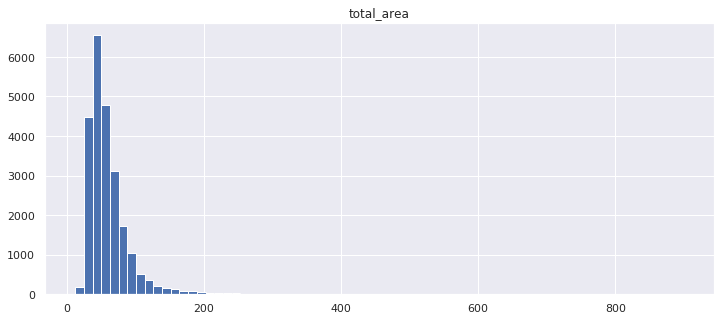

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


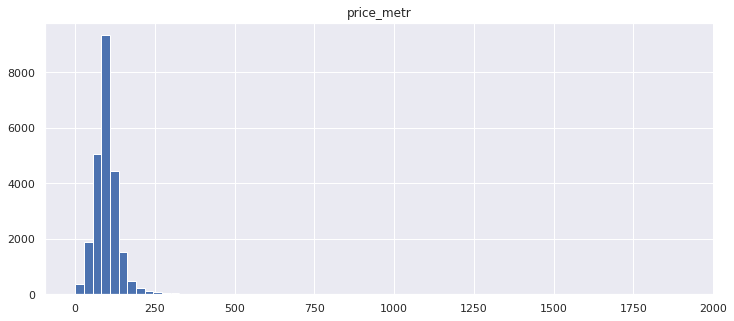

count    23699.000000
mean        99.422170
std         50.309503
min          0.000000
25%         77.000000
50%         95.000000
75%        114.000000
max       1908.000000
Name: price_metr, dtype: float64


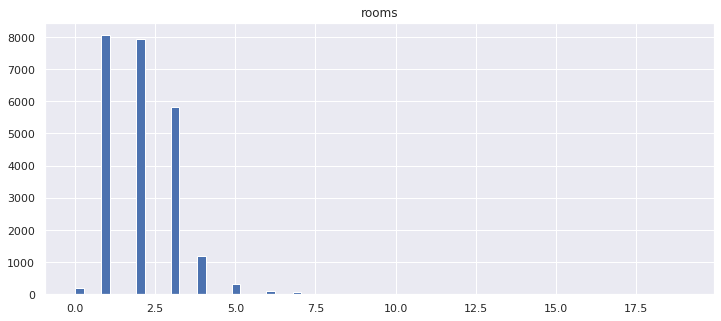

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


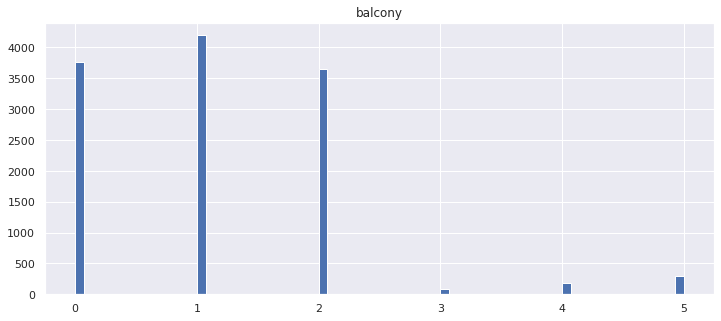

count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64


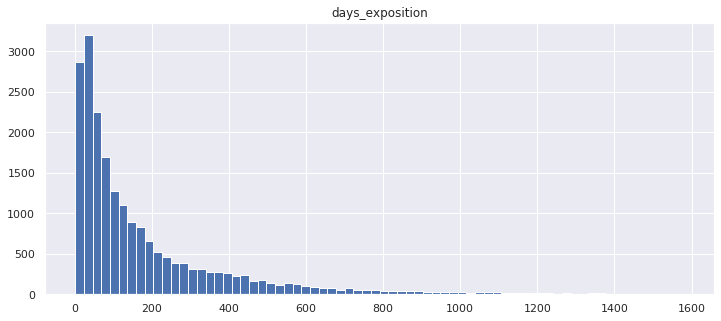

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


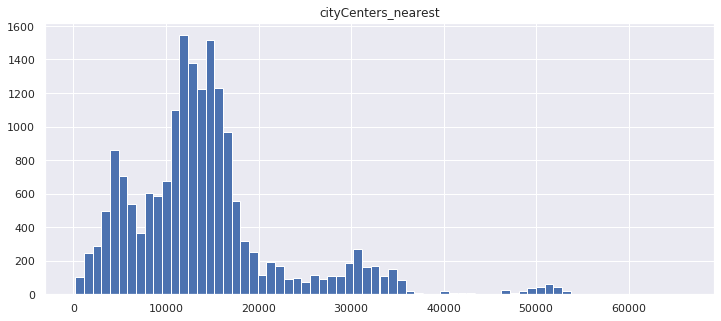

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


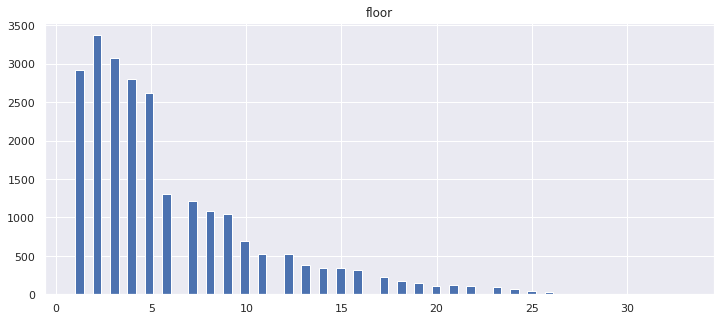

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


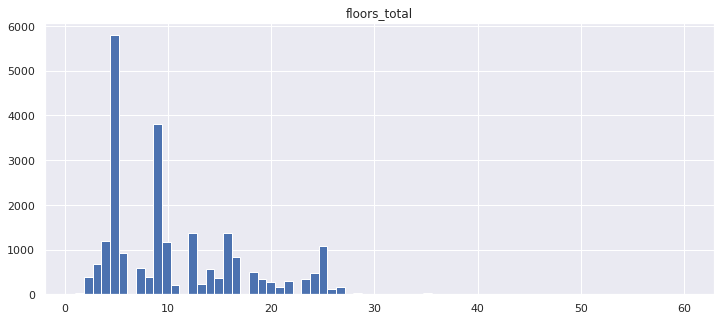

count    23699.000000
mean        10.678678
std          6.591239
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


In [7]:
data_flat['price_metr'] = pd.to_numeric(data_flat['price_metr'], errors='coerce')#меняем на числовой тип

for column in ['total_area', 'price_metr', 'rooms', 'balcony', 'days_exposition', 'cityCenters_nearest', 'floor', 'floors_total']:
        data_flat.hist(column,bins=70)
        plt.show()
        print(data_flat[column].describe())
      

Вывод:
Площадь квартир: средняя площадь продающихся квартир - площадью 52 м.кв.(по медиане), совсем мало 12 метровых(выбросы), совсем немного площадью 200 м.кв. Все, что тянется далее - выбросы.

Цена за метр: мин - 0 - выброс, средняя по медиане 95000 руб. Макс. цена за метр 1 908 тыс.руб - выброс.

Количество комнат: больше всего продается 1 и 2-комнатных квартир, после них идут 3-х комнатные. Также небольшое количество 4-х и 5-ти комнатных квартир. 19 комнатные квартиры - явный выброс.
Балконы: Стандартно продаются квартиры с 0, 1,2 балконами. Есть показатели 3,4,5 - принимаем их за выбросы.

Время продажи квартиры: в среднем квартира продается 95 дней, самые быстрые продажи - 1 день-скорее всего выброс. Боллее реально выглядит значение 1 квартиля - 45 дней - можно считать,что это самые быстрые продажи. Максимально долго - 232 дня. Значение 1580 дней-выброс.

Расстояние от центра - самая удаленная от центра квартира - 3 квартиль - 16293 м. Минимальное расстояние - 181 м. В среднем удаленность - 13098 м. Здесь расположено наибольшее количество квартир. Небольшой всплеск еще в районе 50 км. Считаем, что все, что больше - выброс.

Этажи - наибольшее количество квартир расположено на 1-5 этажах. Меньшее количество на этажах от 6-10. Далее до 25 этажа. Максимальный эатаж - 33 этажа - выглядит вполне реально.

Общее количество этажей: мин- 1 этаж, максимум по 3 квартилю - 16. На графике мы видим, что выборка заканчивается на 27 этажеи есть выброс на отметке 60. Его убираем.



ОТДЕЛЬНО АНАЛИЗИРУЕМ СТОИМОСТЬ КВАРТИР И ВЫСОТУ ПОТОЛКОВ

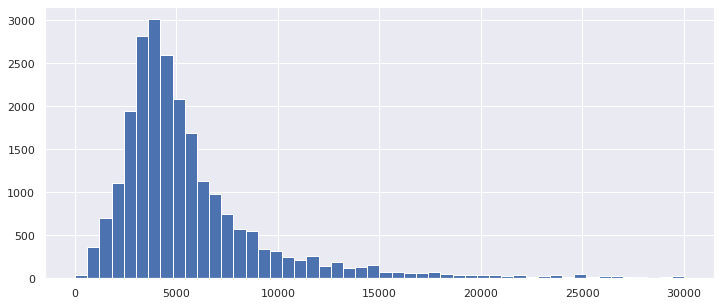

count     23699.000000
mean       6541.548772
std       10887.013268
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64


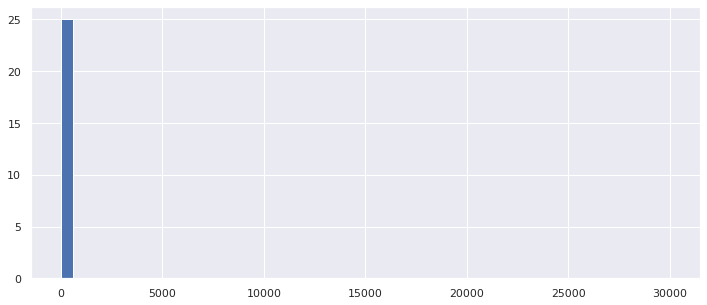

count    23699.000000
mean         2.751594
std          0.987941
min          1.000000
25%          2.600000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


In [8]:
#стоимость квартир и высота потолков
for column in['last_price', 'ceiling_height']:
        data_flat[column].hist(bins=50, range = (10, 30000))
        plt.show()
        print(data_flat[column].describe())



Стоимость квартир: Средняя стоимость квартир находится в промежутке 4 650 млн.руб.
Есть большой выброс в промежутке 12 190 рублей - слишком низкая нереальная стоимость. Максимальная стоимость 763 млн руб - небольшое количество - выброс. реальный разброс цен от 3 400 млн до 6 800 млн. По графику можно увидеть, что на явный "хвост" начинается после 20м.

Высота потолков: Минимальная высота потолков - 1 м - явный выброс - в жизни такого не быват. Стандартно квартиры имеют высоту потолка 2,5,  2,65, 2,8  и максимальная 3,1 м. высота 100 м - выброс.


УБИРАЕМ ВЫБРОСЫ ИЗ ДАННЫХ

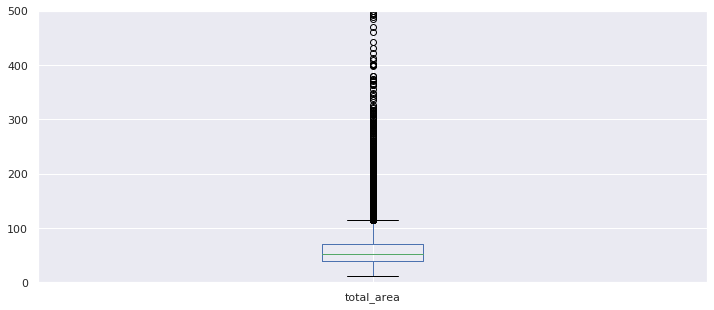

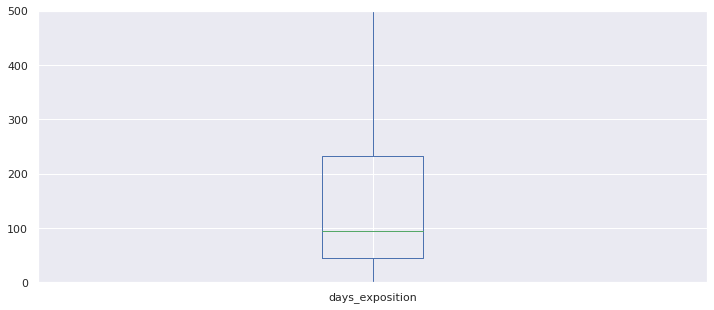

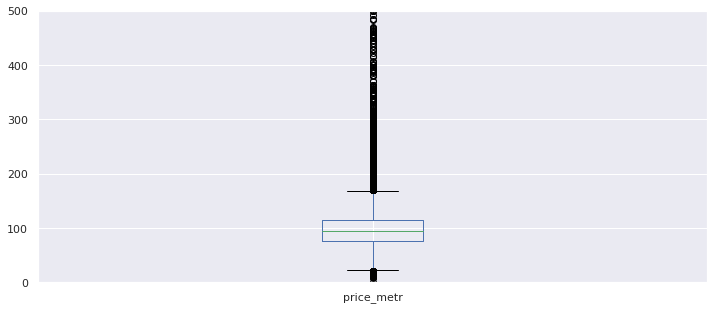

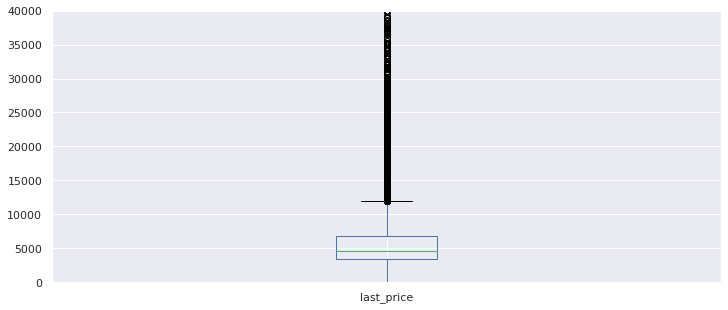

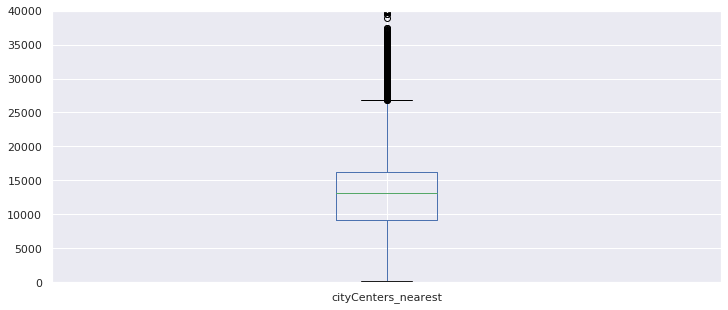

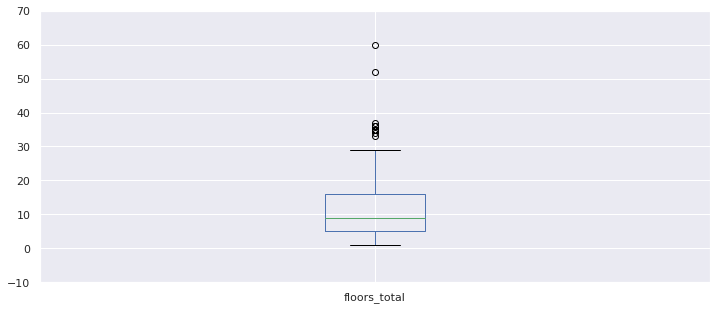

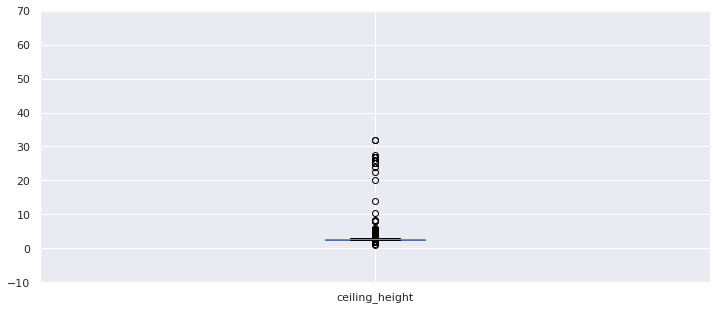

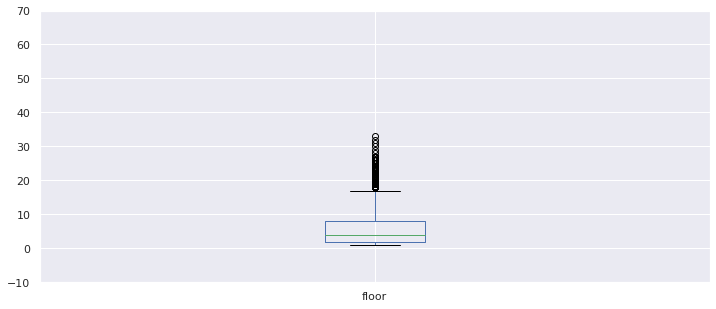

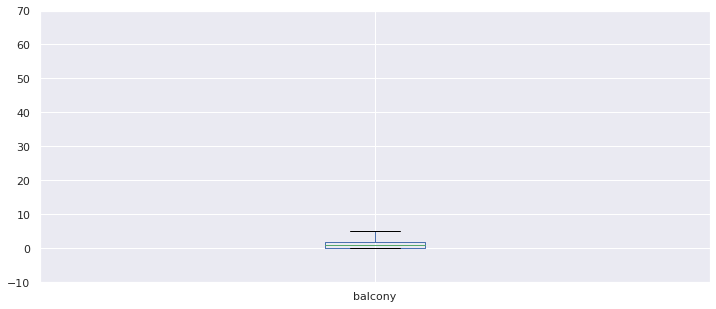

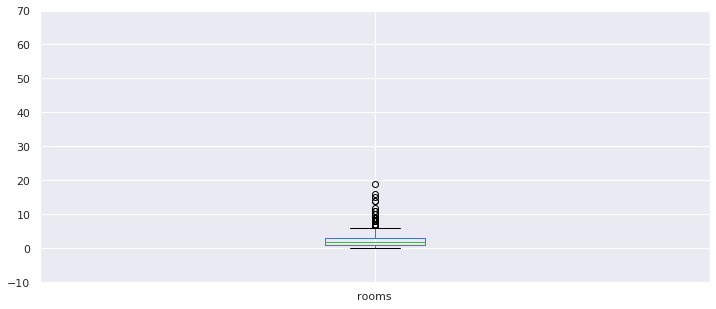

In [9]:
for column in['total_area', 'days_exposition', 'price_metr']:
        data_flat.boxplot(column)
        plt.ylim(0,500)
        plt.show()
        
for column in['last_price', 'cityCenters_nearest']:
        data_flat.boxplot(column)
        plt.ylim(-10,40000)
        plt.show()   
        
for column in['floors_total', 'ceiling_height', 'floor', 'balcony', 'rooms']:
        data_flat.boxplot(column)
        plt.ylim(-10,70)
        plt.show()        
        

## фиксируем границы выборки##


In [10]:
good_area = data_flat.query('total_area<300')
good_price = data_flat.query('(last_price > 3400)and (last_price < 30000)')
good_ceiling_height = data_flat.query('(ceiling_height > 2) and (ceiling_height < 4)')
good_price_metr = data_flat.query('(price_metr > 77)and (price_metr < 285)')
good_price_rooms = data_flat.query('rooms < 6')
good_price_balcony = data_flat.query('balcony < 5')
good_days_exposition = data_flat.query('(days_exposition > 45) and (days_exposition < 528)')
good_cc = data_flat.query('(cityCenters_nearest < 26500)')
good_floors_total = data_flat.query('(floors_total < 30)')
good_floor = data_flat.query('(floor > 0) and (floor < 19)')


При определении выбросов ориентируемся на 1 и 3 квартили и стандартные "усы".
Создаем data_filtered в которой определяем срез по стоимости и высоте потолков. Данный фильтр выбран как унифицированный для отсечения ненужных данных, остальные фильтры задаем отдельно и применяем при выполнении след.заданий.
Выбросы убираем в след.параметрах:общая площадь - задаем меньше 200 м, стоимость - ограничиваем 1 квартилем и убираем данные после 30 000тыс.Высота потолков - ограничиваем от 2.4 до 4 м(задаем потолки 4 вместо 3.1 м(если ориентируемся на квартили), т.к.иногда бывают двухуровневые квартиры со 2-м светом, у которых потолки 4-5 м.

Остальные фильтры:

Количество комнат - максимальное кол-во комнат было 19,на графике видно,что у нас есть 6 комнатные и 7 комнатные(совсем немного) - ограничиваем 6 комнатами - в жизни такое реально.
Количество дней экспозиции - ограничиваем 1 и 3 квартилем. Больше 232 дней экспозиции больше похоже на выставку.
Балконы - ограничиваем 2 шт.  Больше обычно не бывает.
Для просмотра недвижимости,расположенной ближе к центру будем использовать медианное значение - 16293.
Общее количество этажей - ограничиваем 34, т.к. у нас имеется квартира на 33 этаже.


,last_price,price_metr
cityCenters_nearest_1,-0.344362,-0.379411
cityCenters_nearest,-0.344362,-0.379411
living_k_total,-0.089570,-0.196982
rooms,0.522700,-0.073308
launch_date,-0.022046,-0.018262
launch_month,0.003595,-0.004495
open_plan,-0.035169,0.009262
days_exposition,0.133704,0.023811
studio,-0.053784,0.029243
living_area,0.650744,0.030046


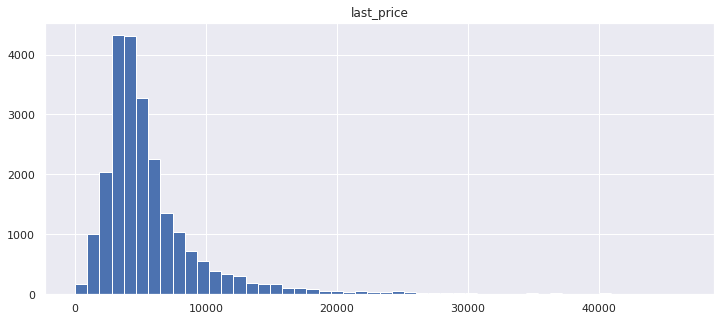

In [11]:
#Проверяем корреляцию цены за метр и остальных параметров
data_flat.hist('last_price', bins=50, range=(0,data_flat['last_price'].median()*10));

data_filtered = data_flat.query('last_price < 30000 and ceiling_height > 2 and ceiling_height < 4')
      
data_filtered.corr()[['last_price','price_metr']].sort_values('price_metr')

Имеется корреляция (взаимосвязь) цены и всех параметров квартиры. Везде показатель больше или меньше 0.


## ФАКТОРЫ,ВЛИЯЮЩИЕ НА СТОИМОСТЬ КВАРТИР

- анализируем взаимосвязь цены и общей площади, количество комнат и цены за м.кв., долю квартир, вошедших в выборку.


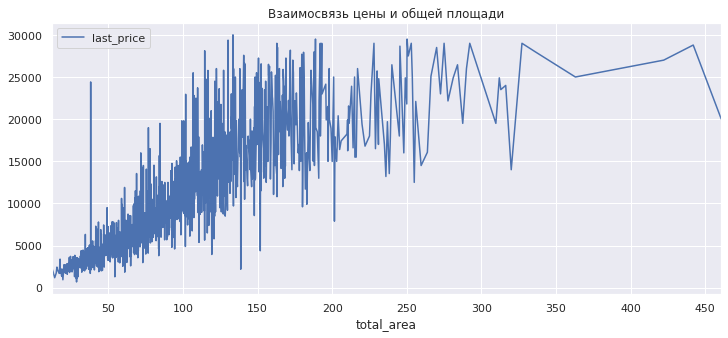

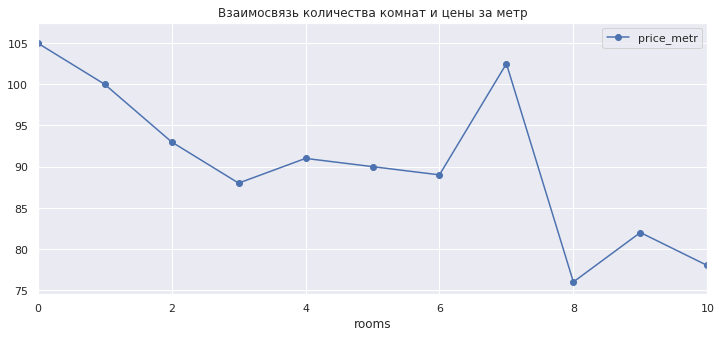

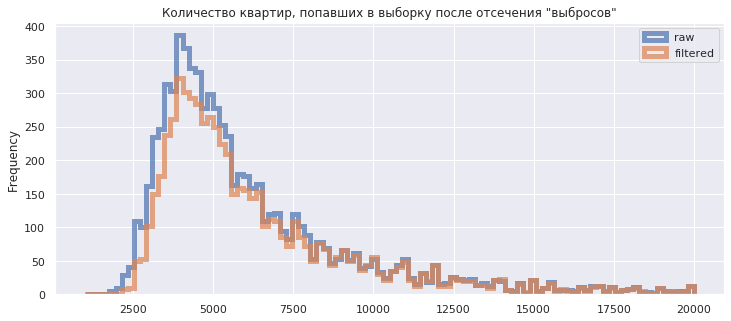

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


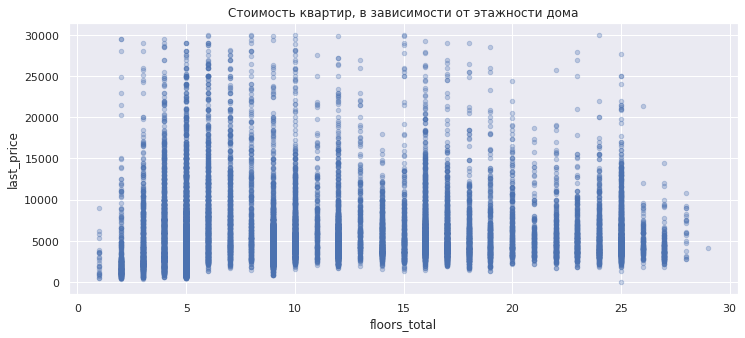

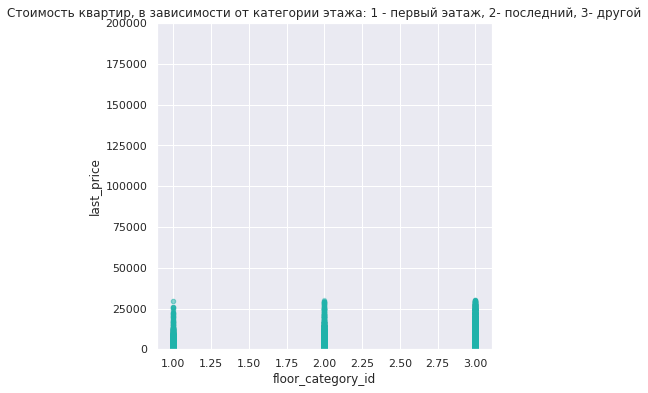

In [12]:
#строим графики:
#Взаимосвязь цены и общей площади
(data_filtered
        .pivot_table(index='total_area', values='last_price', aggfunc='median')
        .plot(grid=True, figsize=(12, 5), title='Взаимосвязь цены и общей площади')
) 
plt.show()

#строим график 'Взаимосвязь количества комнат и цены за метр
(data_filtered
        .pivot_table(index='rooms', values='price_metr', aggfunc='median')
        .plot(style='-o', xlim=(0,10), title='Взаимосвязь количества комнат и цены за метр')
) 
plt.show()

#строим график 'Доля квартир, после очистки выбросов
good_cc = data_flat.query('cityCenters_nearest < 26500')

med_cc = data_filtered.pivot_table(index="cityCenters_nearest", values="last_price", aggfunc="median")
good_cc = good_cc.pivot_table(index="cityCenters_nearest", values="last_price", aggfunc="median")

ax = med_cc.plot(kind='hist', y='last_price', histtype='step', range=(1000, 20000), bins=100, linewidth=5, alpha=0.7, label='raw')
good_cc.plot(kind='hist', y='last_price', histtype='step', range=(1000, 20000), bins=100, linewidth=5, alpha=0.7, label='filtered', ax=ax, grid=True, legend=True, title='Количество квартир, попавших в выборку после отсечения "выбросов"')

plt.show()
#строим график Стоимость квартир, в зависимости от этажности дома
good_floors_total = data_filtered.query('(floors_total < 30)')
good_floors_total.plot(x='floors_total', y='last_price', kind='scatter', alpha=0.3, title='Стоимость квартир, в зависимости от этажности дома')

plt.show()
#строим график Стоимость квартир, в зависимости от категории этажа
data_filtered.plot(x='floor_category_id', y='last_price', ylim=(0,200000), alpha=0.3, color='LightSeaGreen',title='Стоимость квартир, в зависимости от категории этажа: 1 - первый эатаж, 2- последний, 3- другой', kind='scatter', figsize=(6,6),grid=True)


- анализируем зависимость стоимости от м.кв., года, месяца и даты запуска продажи


Зависимость стоимости квартиры от квадратного метра


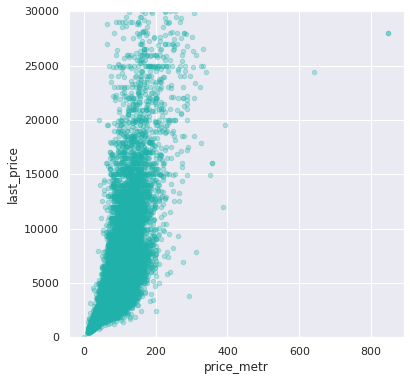

Зависимость цены от года запуска


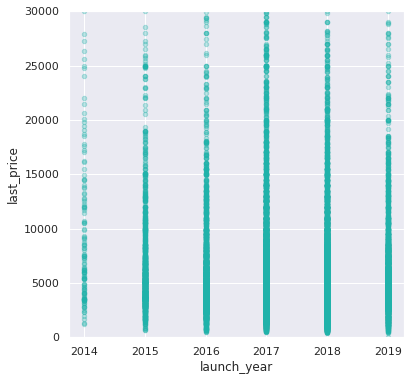

Зависимость цены от месяца запуска


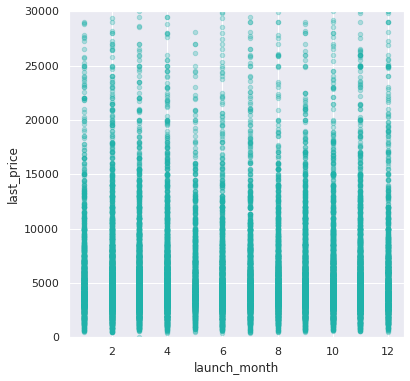

Зависимость цены от даты запуска


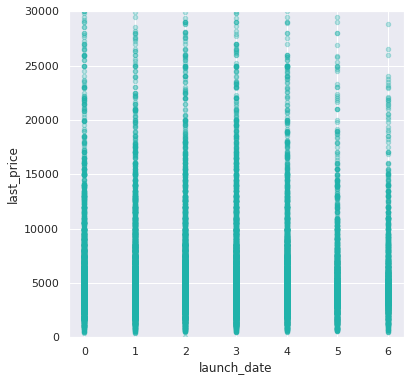

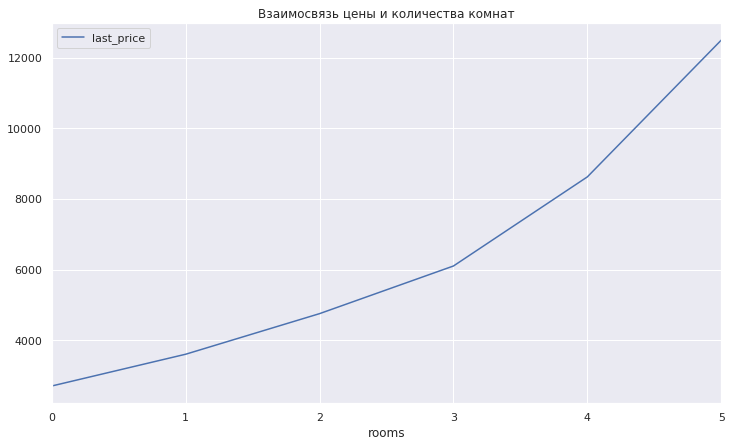

In [13]:
for column in['price_metr', 'launch_year', 'launch_month', 'launch_date']:
    if column == 'price_metr': print('Зависимость стоимости квартиры от квадратного метра')
    data_filtered.plot(x=column, y='last_price', ylim=(0,30000), alpha=0.3, color='LightSeaGreen', kind='scatter', figsize=(6,6),grid=True)
    if column == 'launch_year': print('Зависимость цены от года запуска')
    if column == 'launch_month': print('Зависимость цены от месяца запуска')
    if column == 'launch_date':  print('Зависимость цены от даты запуска')
    plt.show()

(data_filtered
        .query('rooms < 6')          
        .pivot_table(index='rooms', values='last_price', aggfunc='median')
        .plot(grid=True, figsize=(12, 7), title='Взаимосвязь цены и количества комнат')
) 
            

Вывод: 
1.Стоимость квартиры растет пропорционально площади квартиры (гр 1).
2.Зависимость стоимости квадратного метра и количества комнат - стоимость снижается с количеством комнат и делает резкий скачок на 7 комнатных квартирах.
3.Зависимость от удаленности от центра - практически прямая - чем дальше от центра -стоимость меньше. На графике отражена выборка квартирБ оставшися после отсечения выбросов.
4.Cтоимость квартиры в центре - самая высокая - гр.2. По мере удаления от центра - снижается стоимость.
5.Зависимость от этажности - есть, наибольшая стоимость 11 и 29-этажных домах.
6.Зависимость от категории этажа - есть- дороже всего квартиры, расположенные между первым и последним этажами.
7.Зависимость между стоимостью квадратного метра и стоимостью квартиры есть - указано на графике- с ростом квадратного метра растет общая цена.
8.Зависимость от года размещения объявления - наибольшая стоимость квартир была в 2017 году, далее был небольшой спад.
9.Зависимость от месяца размещения - небольшая, примерно одинаково распределена стоимость по месяцам, разве что в июле чуть меньше объявлений и стоимость квартир.
10.Зависимость от даты размещения - примерно одинаково во все дни недели, в четверг(3) концентрация немного выше.
11.Взаимосвязь цены от количества комнат - прямая - чем больше комнат тем больше стоимость.


In [14]:
print('Средняя стоимость квадратного метра в топ-10 населенных пунктов')
print()
data_filtered.groupby('lemmas')['price_metr'].mean()

Средняя стоимость квадратного метра в топ-10 населенных пунктов



lemmas
Санкт-Петербург       110.326894
город Всеволожск       68.607595
город Выборг           58.210300
город Гатчина          68.816393
город Колпино          75.338279
город Пушкин          102.778082
другое                 58.496728
поселок Кудрово        95.354565
поселок Мурино         86.054422
поселок Парголовый     90.140673
поселок Шушары         78.700000
Name: price_metr, dtype: float64

In [15]:
print('Стоимость жилья в топ-10 населенных пунктов')
data_filtered.groupby('lemmas')['last_price'].max()

Стоимость жилья в топ-10 населенных пунктов


lemmas
Санкт-Петербург       29999.0
город Всеволожск      24412.9
город Выборг          19990.0
город Гатчина         13900.0
город Колпино         12750.0
город Пушкин          29500.0
другое                28000.0
поселок Кудрово       13000.0
поселок Мурино         8500.0
поселок Парголовый     9140.0
поселок Шушары        10990.0
Name: last_price, dtype: float64

Наибольшая стоимость квадратного метра в городах: Санкт-Петербург - 110 326 руб, 2-е -  г.Пушкин - 102 778руб.,
Третье место - поселок Кудрово - 95353 руб. Далее: поселок Парголовый - 90140 руб., поселок Мурино - 86054 руб, поселок Шушары - 78700 руб и город Колпино 75 338 руб.

Самая большая стоимость жилья в С.Петербурге - 29,999 млн.руб, далее идут: Всеволожск - 24,412 м.руб. и город Выборг - 19,990 м.руб.
Наименьшая стоимость жилья в поселке Шушары - 10,990 руб.

## ВЫДЕЛЯЕМ СЕГМЕНТ КВАРТИР В ЦЕНТРЕ 

<BarContainer object of 32 artists>

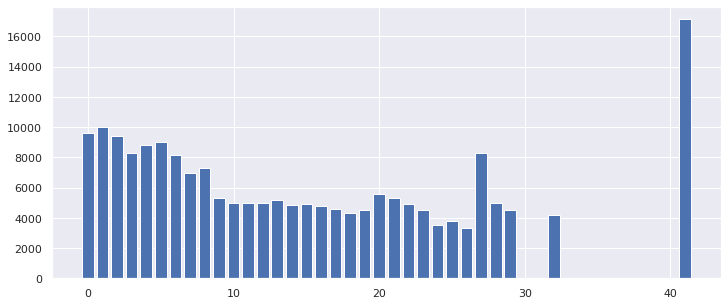

In [16]:

data_filtered['cityCenters_nearest_km']=data_filtered['cityCenters_nearest'] / 1000
data_filtered['cityCenters_nearest_km'] = data_filtered['cityCenters_nearest_km'].round()
data_filtered.head()

flats_in_peterburg = data_filtered.query('lemmas == "Санкт-Петербург"')
flats_in_peterburg_grouped = flats_in_peterburg.groupby('cityCenters_nearest_km')['last_price'].median()
plt.bar(flats_in_peterburg_grouped.index, flats_in_peterburg_grouped)

В промежутке между 8 и 9 заметен скачок цены - принимаем данное резкое изменение как изменение района. В центр города входят квартиры в области 8 км. 

## Анализируем все факторы для квартир в центре


- Анализируем площадь квартир в центре, долю квартир в центреБ взаимосвязь комнат и цены за м.кв.

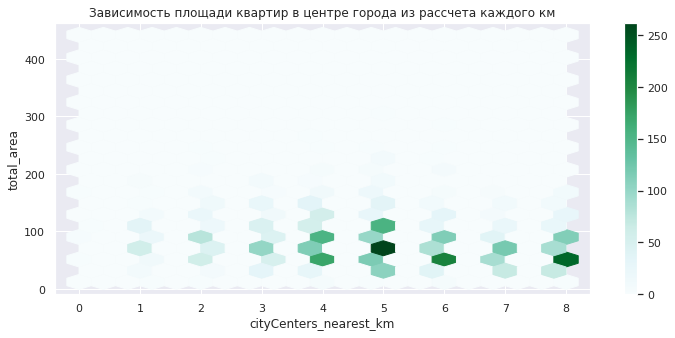

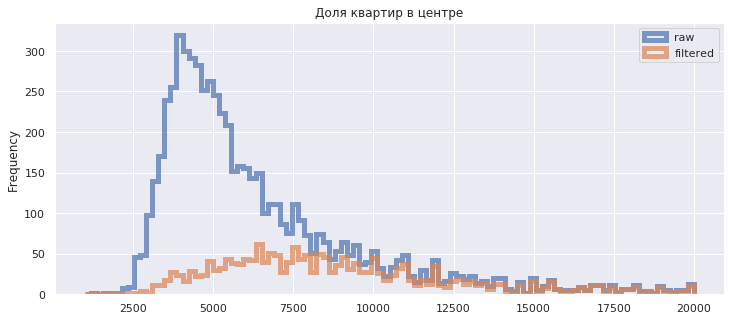

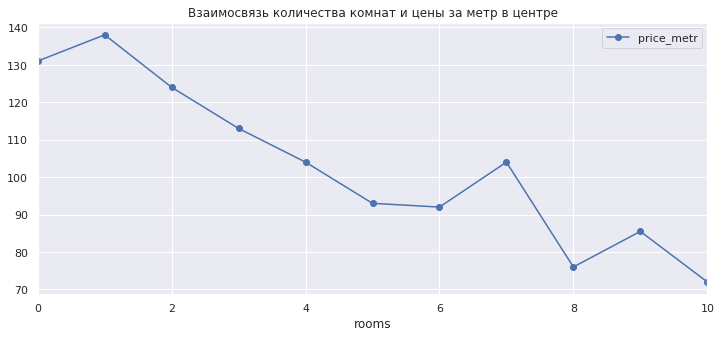

In [17]:
flats_in_peterburg_centr = data_filtered.query('cityCenters_nearest_km <= 8')
flats_in_peterburg_centr.plot(x='cityCenters_nearest_km', y='total_area',kind='hexbin', gridsize=20,sharex=False, title='Зависимость площади квартир в центре города из рассчета каждого км')
plt.show()

#Доля квартир в центре
good_cc = data_filtered.query('cityCenters_nearest_km < 26')
med_cc = good_cc.pivot_table(index="cityCenters_nearest", values="last_price", aggfunc="median")
grouped_spb_centr = flats_in_peterburg_centr.pivot_table(index="cityCenters_nearest", values="last_price", aggfunc="median")
ax = med_cc.plot(kind='hist', y='last_price', histtype='step', range=(1000, 20000), bins=100, linewidth=5, alpha=0.7, label='raw')
grouped_spb_centr.plot(kind='hist', y='last_price', histtype='step', range=(1000, 20000), bins=100, linewidth=5, alpha=0.7, label='filtered', ax=ax, grid=True, legend=True, title='Доля квартир в центре')
plt.show()


(flats_in_peterburg_centr
        .pivot_table(index='rooms', values='price_metr', aggfunc='median')
        .plot(style='-o', xlim=(0,10), title='Взаимосвязь количества комнат и цены за метр в центре')
) 
plt.show()





- Анализируем параметры: площадь, цена,число комнат, высота потолков.

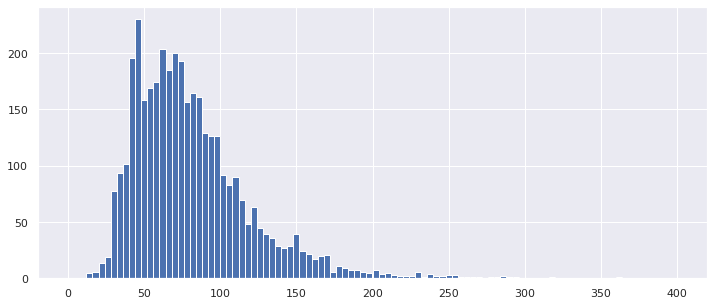

count    3795.000000
mean       80.923275
std        39.627344
min        12.000000
25%        53.000000
50%        72.900000
75%        98.000000
max       441.980000
Name: total_area, dtype: float64


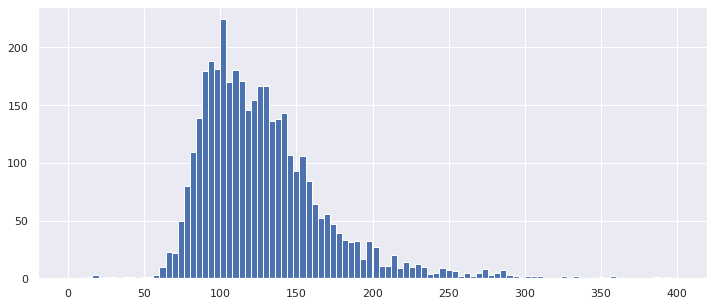

count    3795.000000
mean      127.459816
std        44.207467
min        15.000000
25%        99.000000
50%       120.000000
75%       146.000000
max       848.000000
Name: price_metr, dtype: float64


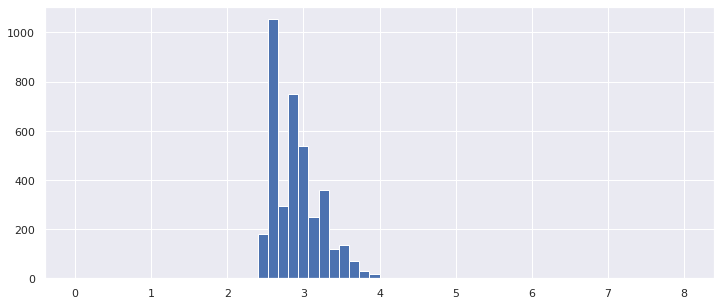

count    3795.000000
mean        2.903159
std         0.297239
min         2.400000
25%         2.650000
50%         2.800000
75%         3.100000
max         3.980000
Name: ceiling_height, dtype: float64


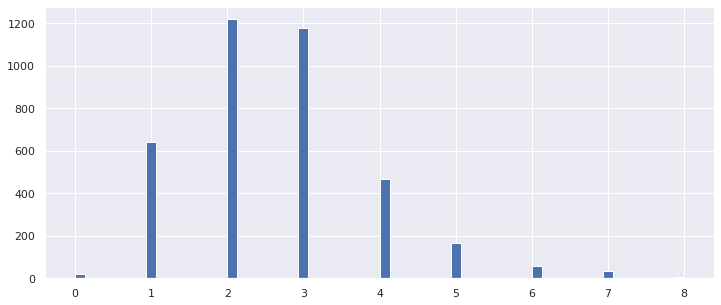

count    3795.000000
mean        2.640843
std         1.303200
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        16.000000
Name: rooms, dtype: float64


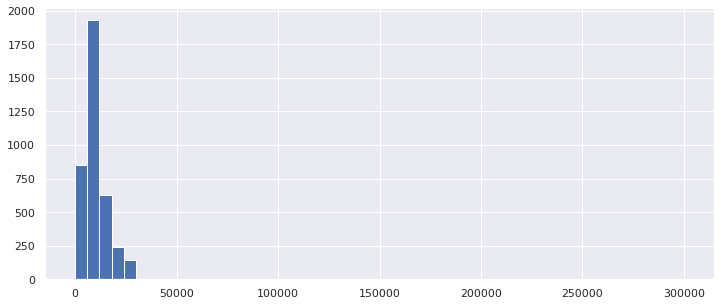

count     3795.000000
mean     10086.745775
std       5535.487923
min       1600.000000
25%       6231.574000
50%       8500.000000
75%      12400.000000
max      29999.000000
Name: last_price, dtype: float64


In [18]:
#Анализируем параметры: площадь, цена,число комнат, высота потолков.
for column in['total_area', 'price_metr']:
        flats_in_peterburg_centr[column].hist(bins=100,range=(0,400))
        plt.show()
        print(flats_in_peterburg_centr[column].describe())


for column in['ceiling_height', 'rooms']:
        flats_in_peterburg_centr[column].hist(bins=60,range=(0,8))
        plt.show()
        print(flats_in_peterburg_centr[column].describe())

flats_in_peterburg_centr['last_price'].hist(bins=50,range=(0,300000))
plt.show()
print(flats_in_peterburg_centr['last_price'].describe()) 

Вывод по параметрам квартир в центре города:
1.Стоимость квартир в радиусе 8 км.(центр) выше.
Средняя стоимость м.кв. составляет 120 тыс.руб. против 95 тыс.руб за метр по всей базе С.Петербурга и области.

2.Средняя площадь квартир в центре больше - 72 м.кв. против 52 м.кв.
3.Средняя стоимость квартир в центре выше 8,5 м.руб против 4,6 м.руб. по всей выборке.
4.Количество комнат в центре 3 (среднее) против 2-х в области, количество многокомнатных квартир также выше.
5.Стоимость м.кв. снижается при увеличении количества комнат(после 1), в общей выборке снижается после 0(новострой либо квартира студия) и делает резкий скачок на 6 комнатной квартире (общее для обоих выборок) и потом опять падает. В целом, можно сказатьБ что здесь тенденция одинаковая.
5.Высота потолков (средняя) выше - 2.8 м. против 2.65 во всей базе после фильтрации.

Общий вывод - квартиры в центре дороже и комфортабельнее.


<div class="alert alert-danger">
<h2> Комментарий ревьюера</h2>

Давай в ячейках 16 и 17 постараемся автоматизировать построение графиков.    
</div>

## ФАКТОРЫ ВЛИЯЮЩИЕ НА СТОИМОСТЬ КВАРТИР

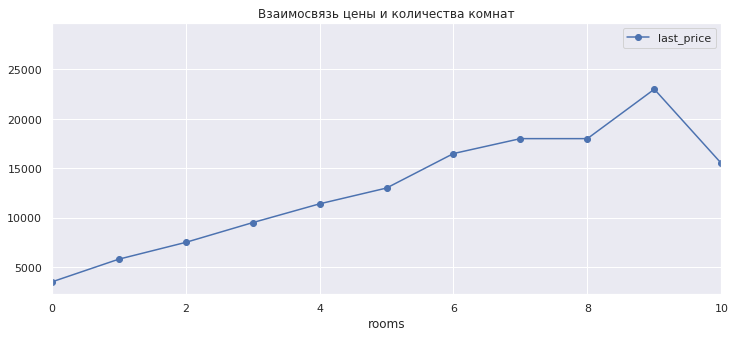

In [19]:
(flats_in_peterburg_centr
        .pivot_table(index='rooms', values='last_price', aggfunc='median')
        .plot(style='-o', xlim=(0,10), title='Взаимосвязь цены и количества комнат')
) 


Зависимость стоимости квартиры от количества комнат


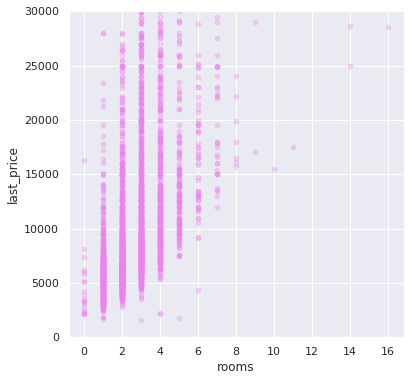

Зависимость цены от от количества этажей


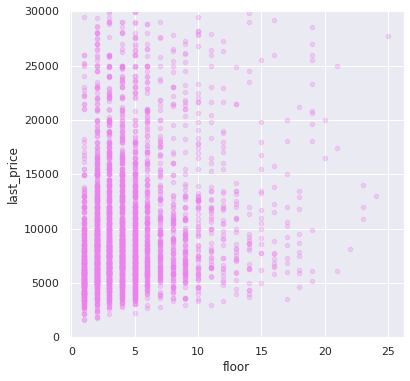

Зависимость цены от удаленности от центра


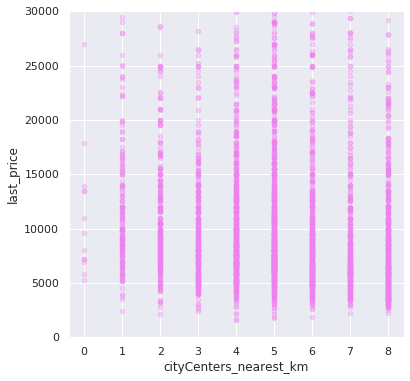

Зависимость цены от даты запуска


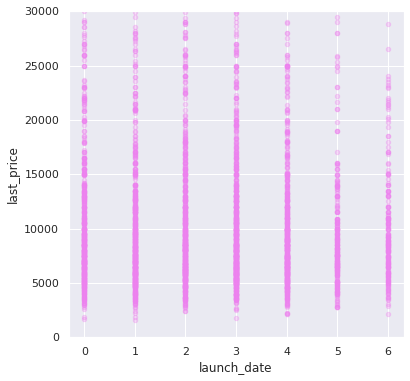

In [20]:
for column in['rooms', 'floor', 'cityCenters_nearest_km', 'launch_date']:
    if column == 'rooms': print('Зависимость стоимости квартиры от количества комнат')
    flats_in_peterburg_centr.plot(x=column, y='last_price', ylim=(0,30000), alpha=0.3, color='Violet', kind='scatter', figsize=(6,6),grid=True)
    if column == 'floor': print('Зависимость цены от от количества этажей')
    if column == 'cityCenters_nearest_km': print('Зависимость цены от удаленности от центра')
    if column == 'launch_date':  print('Зависимость цены от даты запуска')
    plt.show()
       

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Интересный способ определить подписи графиков.
</div>

Вывод:
1.На стоимость квартиры влияет количество комнат - чем больше комнат - выше стоимость.
2.Этаж - влияет на стоимость квартиры - чем выше этаж - тем выше цена.
3.Удаленность от центра - прямая зависимость - чем дальше от центра - тем дешевле.
4.Зависимость от даты размещения - совсем небольшая (общее для всей базы и квартир в центре).


Общий вывод:
Был проанализирован дата-сет с базой данных о продаже квартир в Санкт Петербурге и Ленинградской области.
В результате анализа была выявлена зависимость стоимости цены от удаленности от центра, общего количества этажей, этажа нахождения квартиры, площади квартиры, количества комнат.
Наибольшая зависимость стоимости квартир обнаружена в отношении удаленности от центра(8 км), далее идет зависимость от площади квартир, количества комнат (чем больше комнат тем дороже), далее этаж и этажность дома.   
Найдена небольшая зависимость от времени размещения объявления - месяца и даты, выявлен большой объем объявлений в 2017 году.
    

<div class="alert alert-warning">
<h2> Комментарий ревьюера</h2>

Просьба не удалять мои комментарии. С ними мне проще ориентироваться что было сделано не так.

</div>

## комментарии не удаляла, при загрузке проекта почему-то пропали все ваши комментарии и мои правки, проект загрузился в первоначальном виде

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Возможно произошли какие—то технические сбои, рекомендую перед отправкой работы сохранять у себя проект локально. Чтобы избежать в будущем ситуаций когда работа не подгружается :( 
    
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Вижу, что поправила практически везде автоматизацию построения графиков. Это здорово и безусловно эффективно.
    
---
    
Из дополнительных идей — как же нам ещё оптимизировать свой код, рекоемендую помещать построение графиков в отдельные функции, чтобы не писать циклы несколько раз например. Или наоборот для циклов использовать методы определенные в функции.
    
---
    
В целом сам проект выполнен на хорошем уровне! На протяжении всей работы чувствуется глубина проработки задачи и это безусловный плюс для нас. Было использовано большое количество методов, которые будут помогать тебе в дальнейших проектах.
    
Не стоит забывать про оформление своей работы, это важный такой же важный этап. Рекомендую «не стесняться» использовать ячейки типа **markdown** там где нам необходимо отобразить свои размышления, в том числе с использованием дополнительной стилизации.
 
    
Успехов в новых работах!
    
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Рекомендую посмотреть на дополнительную стилизацию ячеек типа **markdown**.
    
**Жирный**
*Курсив*
    
--- 

# Заголовок первого уровня

--- 
    
## Заголовок первого уровня
  
--- 
Списки:
    
- один 
- два
- три
   
---
    
1. Раз
2. Раз раз
3. Раз два три
    
--- 
    
Отображение `переменных`
    
    
</div>

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод